In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
def load_dTiters(path, name):
    df = pd.read_csv(path, sep='\t', header=None, names=['gt1', 'gt2', name])
    sort_tuple = lambda x: tuple(sorted([x['gt1'], x['gt2']]))

    df['gt'] = df.apply(sort_tuple, axis=1) ## estimated distances are symmetrical; group and remove duplicates
    df.drop(['gt1', 'gt2'], axis=1, inplace=True)
    
    df.drop_duplicates(inplace=True)
    df = df.pivot_table(index=['gt'])

    return df

dTiter_df_paths = {
    'full': '../data/frequencies/titered_genotype_Dij.tsv',
    'monovalent': '../titer_model/rarefaction/monovalent_output/genotype_Dij.tsv',
    'nhp': '../titer_model/rarefaction/nhp_output/genotype_Dij.tsv',
    'nhp_n1': '../titer_model/rarefaction/rarefaction_n1_output/genotype_Dij.tsv',
    'nhp_n3': '../titer_model/rarefaction/rarefaction_n3_output/genotype_Dij.tsv',
    'nhp_n5': '../titer_model/rarefaction/rarefaction_n5_output/genotype_Dij.tsv'
}

dTiter_dfs = {}

for dataset, path in dTiter_df_paths.items():
    dTiter_dfs[dataset] = load_dTiters(path, dataset)

df = pd.concat(dTiter_dfs.values(), axis=1)
df = df.reindex(columns=['nhp_n1', 'nhp_n3', 'nhp_n5', 'nhp', 'monovalent', 'full'])

In [3]:
df.head()

,nhp_n1,nhp_n3,nhp_n5,nhp,monovalent,full
gt,,,,,,
"(DENV1 I, DENV1 I)",0.0,0.0,0.0,0.0,0.0,0.0
"(DENV1 I, DENV1 II)",0.0,0.6,0.0,0.0,0.0,0.0
"(DENV1 I, DENV1 IV)",0.0,0.0,0.0,0.0,0.0,0.0
"(DENV1 I, DENV1 V)",0.0,0.7,0.5,0.3,0.6,0.6
"(DENV1 I, DENV2 AMERICAN)",3.2,2.5,3.9,3.0,0.4,2.7


In [79]:
def plot_heatmap(name, ax=None, vmax = df.max().max(), xlabel=None):

    dataset = pd.read_csv(dTiter_df_paths[name], sep='\t', header=None, names=['gt1', 'gt2', 'dTiter'])
    dataset = dataset.pivot_table(index='gt1', columns='gt2', values='dTiter')

    if ax is None:
        fig, ax = plt.subplots()
    plt.sca(ax)
        
    sns.heatmap(dataset, cmap='viridis', annot=False, square=True, vmax=vmax,
            annot_kws={'fontsize': 8}, linewidths=1, ax=ax, cbar = False, xticklabels=False, yticklabels=1)

    ax.set_yticklabels(ax.get_yticklabels(), fontdict={'size': 8})
    ax.set_ylabel('')
    if xlabel:
        ax.set_xlabel(xlabel)
    else:
        ax.set_xlabel('')

In [68]:
def plot_correlation(name1,name2,ax=None,xlabel=None,ylabel=None):
    if ax is None:
        fig, ax = plt.subplots()
    plt.sca(ax)
    corr = stats.linregress(df[name1].values, df[name2].values)
    r_squared = corr[2]**2
    
    sns.regplot(name1,name2,data=df,color='gray', scatter_kws={'alpha': 0.7})
    ax.text(0.1,0.9,r'Pearson $R^2$ = %.2f'%r_squared, transform=ax.transAxes)
    ax.set_xlim(0,5)
    ax.set_ylim(0,5)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    else:
        ax.set_ylabel('')
        
    ax.set_xticks([1,2,3,4,5])
    ax.set_xticklabels([1,2,3,4,5])
    ax.set_aspect(1)

In [25]:
def clear_ax(ax):
    plt.sca(ax)
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    labelleft=False,
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

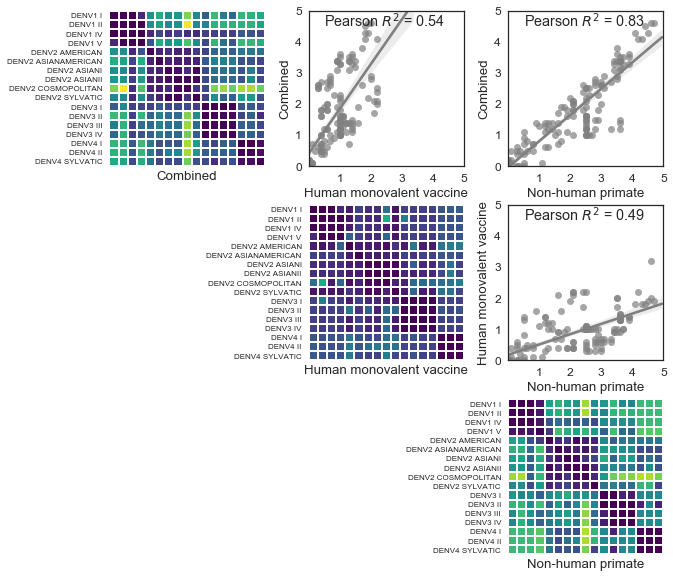

In [80]:
sns.set(style='white', font_scale=1.2)

fig, axes = plt.subplots(nrows=3,ncols=3, figsize=(10,10))

combined_row = axes[0]
monovalent_row = axes[1]
nhp_row = axes[2]

plot_heatmap('full', combined_row[0], xlabel='Combined')
plot_correlation('monovalent', 'full', xlabel='Human monovalent vaccine', ylabel='Combined', ax=combined_row[1])
plot_correlation('nhp', 'full', xlabel='Non-human primate', ylabel='Combined', ax=combined_row[2])

plot_heatmap('monovalent', ax=monovalent_row[1], xlabel='Human monovalent vaccine')
plot_correlation('nhp', 'monovalent', monovalent_row[2], xlabel='Non-human primate', ylabel='Human monovalent vaccine')

plot_heatmap('nhp', ax=nhp_row[2], xlabel='Non-human primate')

for ax in [monovalent_row[0], nhp_row[0], nhp_row[1]]:
    clear_ax(ax)
    
plt.subplots_adjust(wspace = 0.25, hspace=0.25)

plt.savefig('./png/titer_dataset_comparison.png', dpi=300, bbox_inches='tight')

In [71]:
def plot_heatmap(name, ax=None, vmax = df.max().max(), title=None):

    dataset = pd.read_csv(dTiter_df_paths[name], sep='\t', header=None, names=['gt1', 'gt2', 'dTiter'])
    dataset = dataset.pivot_table(index='gt1', columns='gt2', values='dTiter')

    if ax is None:
        fig, ax = plt.subplots()
    plt.sca(ax)
    
    ax.yaxis.tick_right()

    if title:
        ax.set_title(title)
    
    if name=='nhp_n1':
        yticklabels = 1
    else:
        yticklabels = False
    
    sns.heatmap(dataset, cmap='viridis', annot=False, square=True, vmax=vmax,
            annot_kws={'fontsize': 8}, linewidths=1, ax=ax, cbar = False, 
            xticklabels=1, yticklabels=yticklabels)
       
    ax.set_yticklabels(ax.get_yticklabels(), fontdict={'size': 10})
    ax.set_xticklabels(ax.get_xticklabels(), fontdict={'size': 10})
        
    ax.set_xlabel('')
    ax.set_ylabel('')

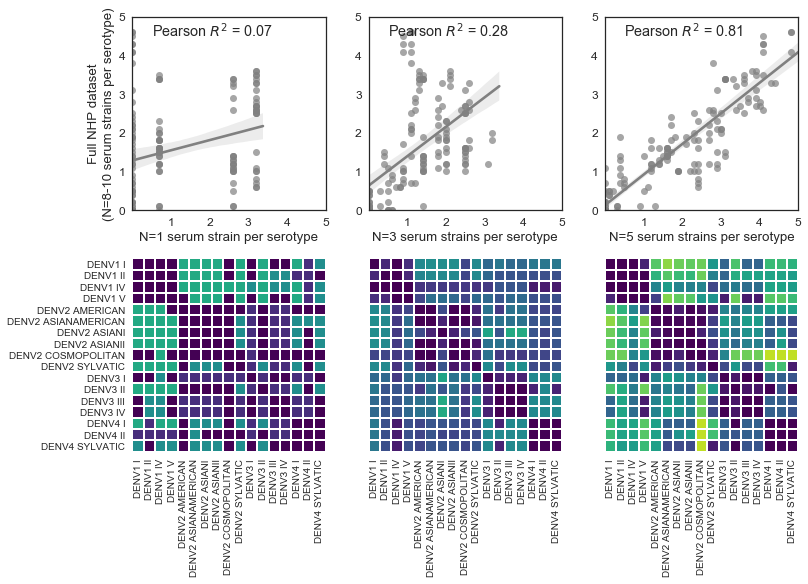

In [74]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12,8))

corr_row = axes[0]
heatmap_row = axes[1]

plot_correlation('nhp_n1', 'full', ax=corr_row[0], xlabel='N=1 serum strain per serotype', ylabel='Full NHP dataset\n(N=8-10 serum strains per serotype)')
plot_correlation('nhp_n3', 'full', ax=corr_row[1], xlabel='N=3 serum strains per serotype', ylabel='')
plot_correlation('nhp_n5', 'full', ax=corr_row[2], xlabel='N=5 serum strains per serotype', ylabel='')

plot_heatmap('nhp_n1', heatmap_row[0])
plot_heatmap('nhp_n3', heatmap_row[1])
plot_heatmap('nhp_n5', heatmap_row[2])

plt.subplots_adjust(wspace = 0.2, hspace=0.25)
plt.savefig('./png/nhp_rarefaction.png', dpi=300, bbox_inches='tight')